# Kitchenware Classifier

In [1]:
import gc
import os
import sys

from collections import defaultdict
from hashlib import md5

import numpy as np
import PIL
import seaborn as sns
import fastai
import torch

from fastai.vision.all import *
from torch import device

print(os.listdir('kitchenware_classifier/data/'))
print('Python       :', sys.version.split("\n")[0])
print('FastAI       :', fastai.__version__)
print('Numpy        :', np.__version__)
print('Torch        :', torch.__version__)
print('CUDA         :', torch.cuda.is_available())

%matplotlib inline

['sample_submission.csv', 'test.csv', 'models', 'train.csv', 'images', 'extra.csv']
Python       : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
FastAI       : 2.7.10
Numpy        : 1.23.5
Torch        : 1.13.1+cu117
CUDA         : True


## Load data and set variables

In [2]:
SEED = 42
set_seed(42)

PROJECT_DIR = Path('kitchenware_classifier')
DATA_DIR = PROJECT_DIR / 'data'
IMG_DIR = DATA_DIR / 'images'

TRAIN_DF = pd.read_csv(DATA_DIR / 'train.csv')
TEST_DF = pd.read_csv(DATA_DIR / 'test.csv')
EXTRA_DF = pd.read_csv(DATA_DIR / 'extra.csv')
TRAIN_DF = pd.concat([TRAIN_DF, EXTRA_DF], ignore_index=True)
TRAIN_DF['image'] = TRAIN_DF['Id'].map(lambda x: f'{x:0>4}.jpg')
TEST_DF['image'] = TEST_DF['Id'].map(lambda x: f'{IMG_DIR}/{x:0>4}.jpg')

In [3]:
display(TRAIN_DF.head())
display(TEST_DF.head())

,Id,label,image
0,560,glass,0560.jpg
1,4675,cup,4675.jpg
2,875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


,Id,image
0,678,kitchenware_classifier/data/images/0678.jpg
1,3962,kitchenware_classifier/data/images/3962.jpg
2,9271,kitchenware_classifier/data/images/9271.jpg
3,5133,kitchenware_classifier/data/images/5133.jpg
4,8842,kitchenware_classifier/data/images/8842.jpg


## EDA

In [4]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6875 entries, 0 to 6874
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6875 non-null   object
 1   label   6875 non-null   object
 2   image   6875 non-null   object
dtypes: object(3)
memory usage: 161.3+ KB


### Check the class distributions

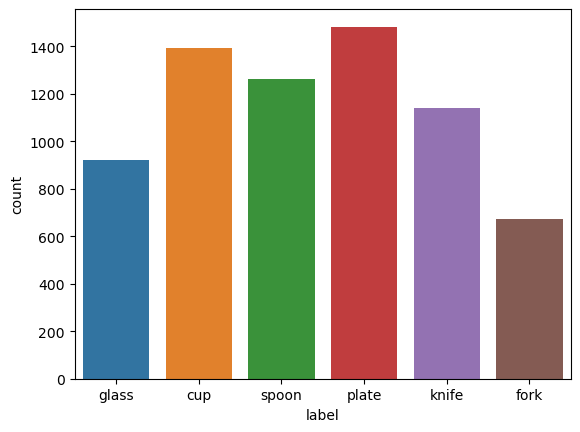

In [5]:
sns.countplot(data=TRAIN_DF, x='label')
plt.show()

### Check for duplicate images

In [6]:
hash_dict = defaultdict(list)
for image in IMG_DIR.glob('*.jpg'):
    with image.open('rb') as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)
len(hash_dict)

10677

In [7]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        if v[0].name != v[1].name:
            duplicate_img.append(v[0])
            duplicate_img.append(v[1])
            print(v)
len(duplicate_img)

[Path('kitchenware_classifier/data/images/7103.jpg'), Path('kitchenware_classifier/data/images/5428.jpg')]
[Path('kitchenware_classifier/data/images/4234.jpg'), Path('kitchenware_classifier/data/images/0237.jpg')]
[Path('kitchenware_classifier/data/images/4162.jpg'), Path('kitchenware_classifier/data/images/3458.jpg')]
[Path('kitchenware_classifier/data/images/8532.jpg'), Path('kitchenware_classifier/data/images/6833.jpg')]
[Path('kitchenware_classifier/data/images/7196.jpg'), Path('kitchenware_classifier/data/images/7063.jpg')]
[Path('kitchenware_classifier/data/images/6624.jpg'), Path('kitchenware_classifier/data/images/7469.jpg')]


12

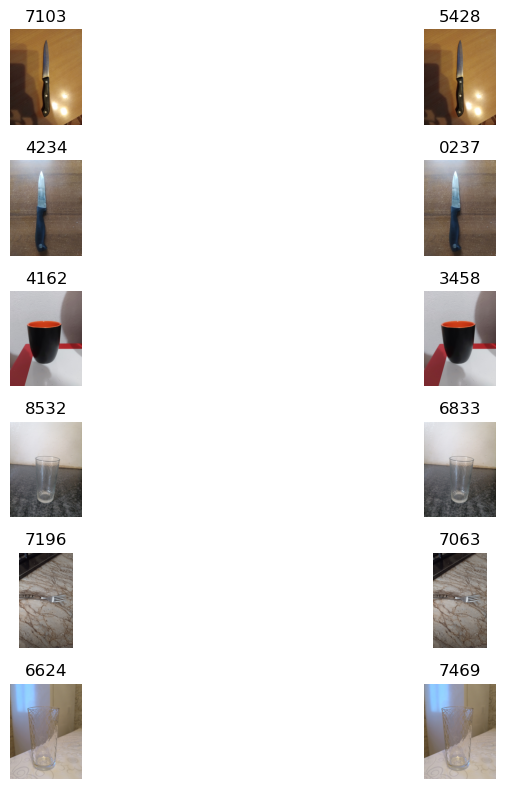

In [8]:
plt.figure(figsize=(12,8))

for idx, img in enumerate(duplicate_img):
    im = PIL.Image.open(img)
    title = img.stem
    plt.subplot(6,2, idx+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
(len(duplicate_img) / len(hash_dict))

0.00112391121101433

> Since the amount of duplicate images are so insignificant, I'm not going to worry about them.

## Data Augmentations

In [10]:
tfms = aug_transforms(
#     min_zoom=1.0,
#     max_zoom=1.1,
    max_lighting=0.2,
#     max_warp=0.2,
#     p_affine=0.75,
    p_lighting=0.75,
    size=224,
)

## Build data loaders

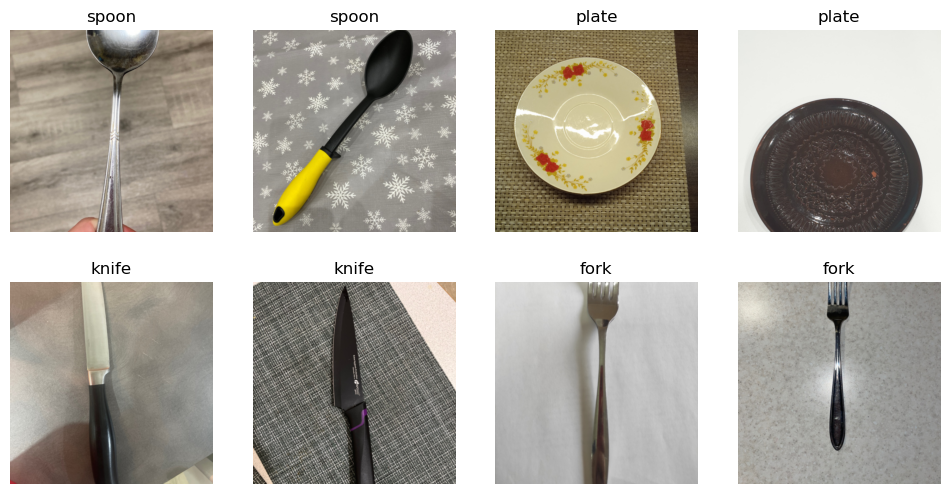

In [11]:
dls = ImageDataLoaders.from_df(
    TRAIN_DF,
    path=str(IMG_DIR),
    valid_pct=0.2,
    seed=42,
    bs=8,
    val_bs=8,
    fn_col='image',
    shuffle=True,
    label_col='label',
    item_tfms=Resize(460),
    batch_ftms=list(tfms),
    device=device('cuda'),
)
dls.show_batch()

## Build learner

In [12]:
def build_learner(model):
    learn = vision_learner(
        dls,
        model,
        metrics=[error_rate, accuracy],
        path=".",
    )
    keep_path = learn.path
    learn.path = DATA_DIR

    print(f"[{model}] Finding best learning rate...")
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    print(f"{lrs=}")

    save_best = SaveModelCallback(
        monitor="valid_loss",
        min_delta=0.000001,
        fname=f"{model}-best_model",
    )
    early_stop = EarlyStoppingCallback(
        monitor="valid_loss",
        min_delta=0.000001,
        patience=3,
    )

    print(f"[{model}] Training the Model...")
    learn.fit(10, lrs.valley, cbs=[save_best, early_stop])
    learn.path = keep_path
    
    return learn

[convnext_nano] Finding best learning rate...


lrs=SuggestedLRs(minimum=0.00831763744354248, steep=1.3182567499825382e-06, valley=0.0010000000474974513, slide=0.001737800776027143)
[convnext_nano] Training the Model...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.475492,0.145904,0.048000,0.952000,01:52
1,0.281070,0.144230,0.045091,0.954909,01:54
2,0.254704,0.131384,0.037091,0.962909,01:54
3,0.203238,0.112680,0.032000,0.968000,01:54
4,0.241572,0.104435,0.033455,0.966545,01:54
5,0.142676,0.112888,0.035636,0.964364,01:54
6,0.198713,0.100207,0.040000,0.960000,01:54
7,0.157350,0.117239,0.040000,0.960000,01:53
8,0.145353,0.105374,0.033455,0.966545,01:53
9,0.157166,0.106375,0.034909,0.965091,01:53


Better model found at epoch 0 with valid_loss value: 0.1459042727947235.
Better model found at epoch 1 with valid_loss value: 0.14423048496246338.
Better model found at epoch 2 with valid_loss value: 0.13138367235660553.
Better model found at epoch 3 with valid_loss value: 0.11267980933189392.
Better model found at epoch 4 with valid_loss value: 0.10443509370088577.
Better model found at epoch 6 with valid_loss value: 0.10020739585161209.
No improvement since epoch 6: early stopping


[resnet50] Finding best learning rate...


lrs=SuggestedLRs(minimum=0.010000000149011612, steep=0.0008317637839354575, valley=0.0030199517495930195, slide=0.002511886414140463)
[resnet50] Training the Model...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.690341,0.276134,0.082909,0.917091,02:25
1,0.464714,0.571033,0.076364,0.923636,02:25
2,0.418905,0.176350,0.056000,0.944000,02:25
3,0.436438,0.151922,0.050909,0.949091,02:26
4,0.358697,0.160722,0.056727,0.943273,02:27
5,0.327950,0.158338,0.051636,0.948364,02:26
6,0.321524,0.150608,0.050909,0.949091,02:26
7,0.287446,0.145568,0.050909,0.949091,02:25
8,0.251906,0.109565,0.037818,0.962182,02:25
9,0.287389,0.128062,0.036364,0.963636,02:26


Better model found at epoch 0 with valid_loss value: 0.27613353729248047.
Better model found at epoch 2 with valid_loss value: 0.17635010182857513.
Better model found at epoch 3 with valid_loss value: 0.15192165970802307.
Better model found at epoch 6 with valid_loss value: 0.15060816705226898.
Better model found at epoch 7 with valid_loss value: 0.14556825160980225.
Better model found at epoch 8 with valid_loss value: 0.10956504195928574.


[xception] Finding best learning rate...


lrs=SuggestedLRs(minimum=0.0033113110810518267, steep=6.309573450380412e-07, valley=0.0006918309954926372, slide=0.0002754228771664202)
[xception] Training the Model...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.334239,0.171339,0.054545,0.945455,03:16
1,0.332958,0.116685,0.039273,0.960727,03:15
2,0.211343,0.113641,0.034909,0.965091,03:16
3,0.240173,0.124317,0.035636,0.964364,03:15
4,0.161398,0.138817,0.036364,0.963636,03:14
5,0.128900,0.110929,0.036364,0.963636,03:14
6,0.111505,0.105911,0.034909,0.965091,03:14
7,0.138880,0.110238,0.035636,0.964364,03:13
8,0.166057,0.112581,0.035636,0.964364,03:13
9,0.097135,0.127324,0.034909,0.965091,03:13


Better model found at epoch 0 with valid_loss value: 0.17133933305740356.
Better model found at epoch 1 with valid_loss value: 0.11668499559164047.
Better model found at epoch 2 with valid_loss value: 0.11364061385393143.
Better model found at epoch 5 with valid_loss value: 0.11092929542064667.
Better model found at epoch 6 with valid_loss value: 0.10591050237417221.
No improvement since epoch 6: early stopping


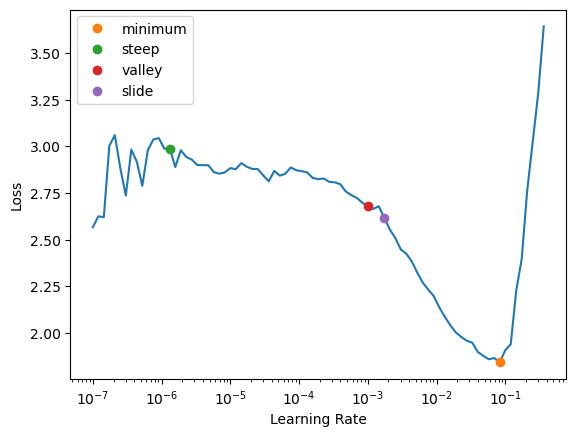

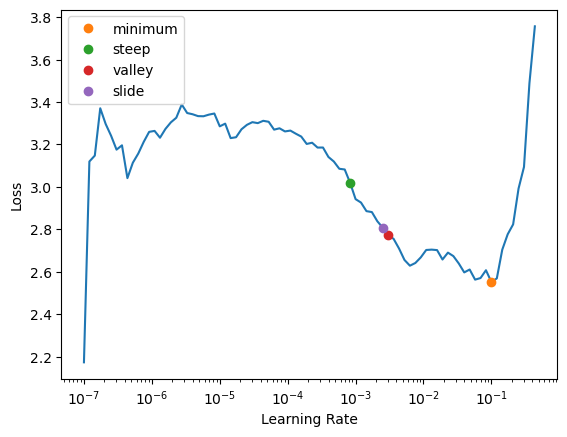

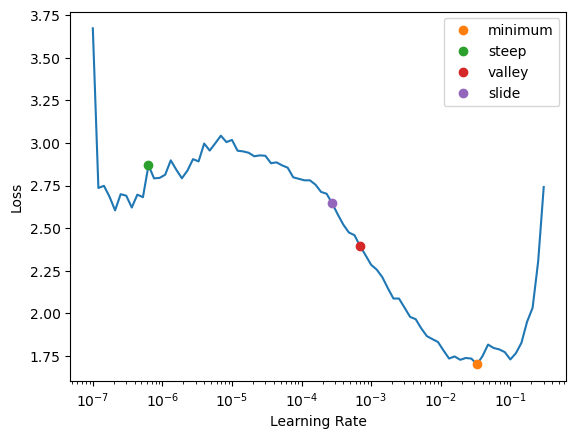

In [13]:
models = ['convnext_nano', 'resnet50', 'xception']
model_metrics = pd.DataFrame(
    columns=['model', 'valid_loss', 'error_rate', 'accuracy', 'minimum', 'steep', 'valley', 'slide', 'learner'])
for model in models:
    learner = build_learner(model)
    val, err, acc = learner.validate()
    model_metrics.loc[len(model_metrics.index)] = [model, val, err, acc, minimum, steep, valley, slide, learner]
    learn = None
    gc.collect()
    torch.cuda.empty_cache()

In [14]:
model_metrics[['model', 'valid_loss', 'error_rate', 'accuracy']]

,model,valid_loss,error_rate,accuracy
0,convnext_nano,0.100207,0.040000,0.960000
1,resnet50,0.109565,0.037818,0.962182
2,xception,0.105911,0.034909,0.965091


In [15]:
best_model = model_metrics.loc[model_metrics['accuracy'] == model_metrics.accuracy.max()]
best_model.model

2    xception
Name: model, dtype: object

In [16]:
learn = best_model.learner.iloc[0]
learn

## Save the model

In [17]:
learn.export("fastai_model.pkl")

## Evaluate results

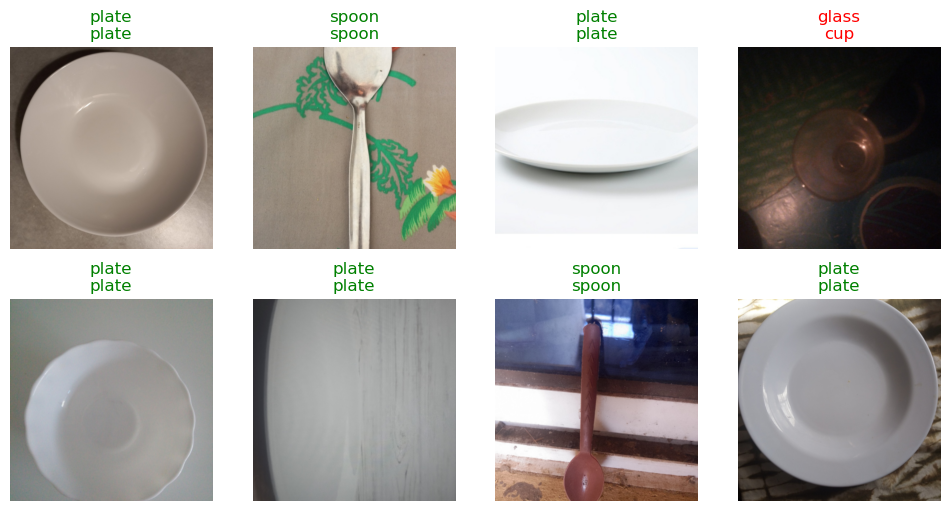

In [18]:
learn.show_results()

In [19]:
interp = Interpretation.from_learner(learn)

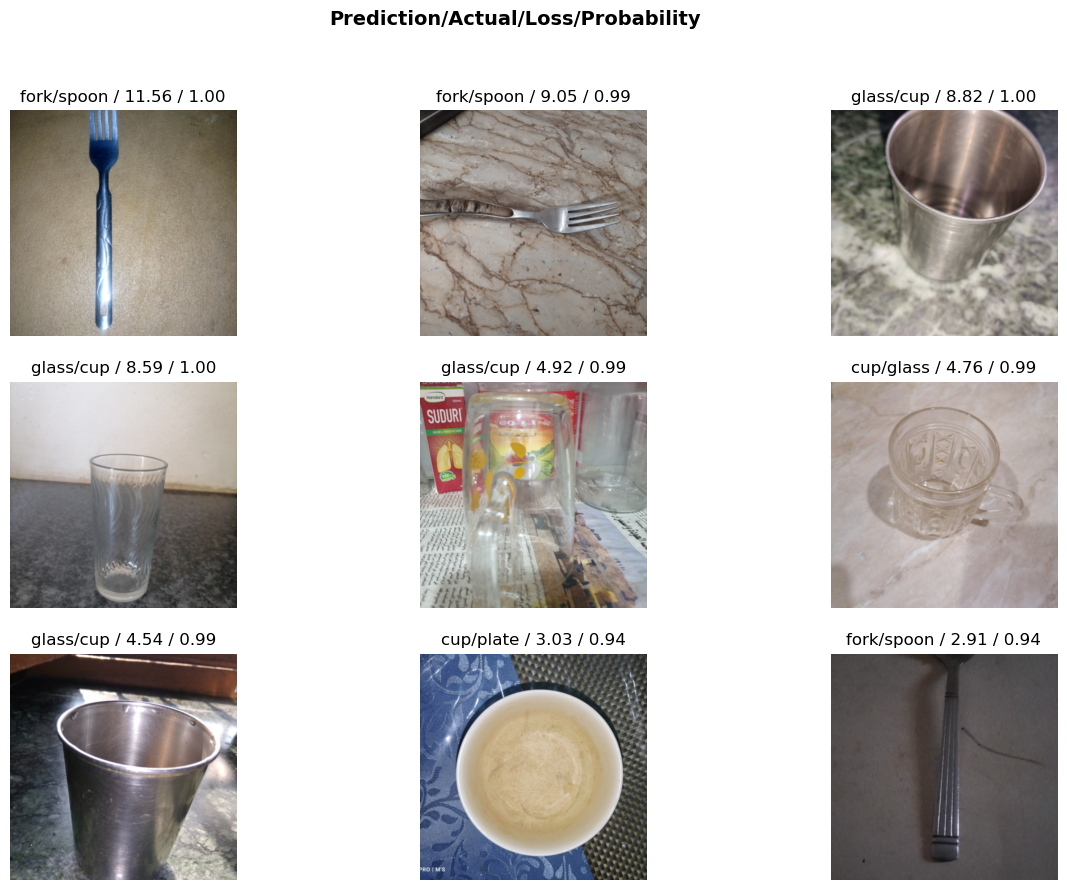

In [20]:
interp.plot_top_losses(9, figsize=(15, 10))

## Predict on testset using (TTA) Test Time Augmentation

In [21]:
tst_dl = dls.test_dl(TEST_DF.image)
tta = learn.tta(dl=tst_dl)

## Create submission file

In [22]:
tta_preds, _ = tta
idxs = tta_preds.argmax(dim=1)
vocab = np.array(dls.vocab)
sub = pd.read_csv(DATA_DIR /'test.csv')
sub['label'] = vocab[idxs]
sub.to_csv('submission.csv', index=False)
sub.head()

,Id,label
0,678,spoon
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork


In [23]:
learn.summary()

Sequential (Input shape: 8 x 3 x 460 x 460)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 32 x 229 x 229  
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 227 x 227  
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 128 x 114 x 114 
Conv2d                                    8192       False     
BatchNorm2d                               256        True      
Conv2d                                    576        False     
____________________________________